# Exercise 06.1

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy import sqrt, log, exp
import math
import scipy
from scipy import constants
import subprocess

sourceDirectory = 'ISING_1D/'

titleSize = 20
axesLabelSize = 15

nSpin = 50
J = 1
blockNumber = 100

In [2]:
def set_input_file(T, J, h, nspin, metro, nblk, nstep, restart, equilibrate):
    subprocess.check_output(["/bin/sh", "-c", 'perl -i -pe "s/^.*.$/'+str(T)+'/ if $. == 1" '+sourceDirectory+"input.dat"])
    subprocess.check_output(["/bin/sh", "-c", 'perl -i -pe "s/^.*.$/'+str(nspin)+'/ if $. == 2" '+sourceDirectory+"input.dat"])
    subprocess.check_output(["/bin/sh", "-c", 'perl -i -pe "s/^.*.$/'+str(J)+'/ if $. == 3" '+sourceDirectory+"input.dat"])
    subprocess.check_output(["/bin/sh", "-c", 'perl -i -pe "s/^.*.$/'+str(h)+'/ if $. == 4" '+sourceDirectory+"input.dat"])
    subprocess.check_output(["/bin/sh", "-c", 'perl -i -pe "s/^.*.$/'+str(metro)+'/ if $. == 5" '+sourceDirectory+"input.dat"])
    subprocess.check_output(["/bin/sh", "-c", 'perl -i -pe "s/^.*.$/'+str(nblk)+'/ if $. == 6" '+sourceDirectory+"input.dat"])
    subprocess.check_output(["/bin/sh", "-c", 'perl -i -pe "s/^.*.$/'+str(nstep)+'/ if $. == 7" '+sourceDirectory+"input.dat"])
    if restart == 'Restart':
        res = '1'
    else:
        res = '0'
    subprocess.check_output(["/bin/sh", "-c", 'perl -i -pe "s/^.*.$/'+str(res)+'/ if $. == 8" '+sourceDirectory+"input.dat"])
    if equilibrate == 'Equilibrate':
        eq = '1'
    else:
        eq = '0'
    subprocess.check_output(["/bin/sh", "-c", 'perl -i -pe "s/^.*.$/'+str(eq)+'/ if $. == 9" '+sourceDirectory+"input.dat"])

def reset_simulation():
    subprocess.check_output(["/bin/sh", "-c", "rm -rf "+sourceDirectory+"output.*"])
    subprocess.check_output(["/bin/sh", "-c", "rm -rf "+sourceDirectory+"seed.out"])
    subprocess.check_output(["/bin/sh", "-c", "rm -rf "+sourceDirectory+"config.final"])
    
def compile_simulation():
    subprocess.check_output(["/bin/sh", "-c", "cd "+sourceDirectory+"; make clean"])
    subprocess.check_output(["/bin/sh", "-c", "cd "+sourceDirectory+"; make"])
    
def run_simulation():
    subprocess.check_output(["/bin/sh", "-c", "cd "+sourceDirectory+"; ./Monte_Carlo_ISING_1D.exe"])

In [3]:
def internal_energy(T):
    th = np.tanh(J/T)
    thN = th**nSpin
    ch = 1/th
    return -J * ( th + ch * thN )/( 1 + thN )

def heat_capacity(T):
    beta = 1 / T
    th = np.tanh(J/T)
    thN = th**nSpin
    ch = 1/th
    return ((beta * J)**2) * (((1 + thN + (nSpin - 1) * (th**2) + (nSpin - 1) * (ch**2) * thN) / (1 + thN))
                            - nSpin * ((th + ch * thN) / (1 + thN))**2)

def magnetization(T, h):
    b = 1 / T
    l1 = np.exp(b * J) * np.cosh(b * h) + np.sqrt(np.exp(2 * b * J) * 
                                                  np.cosh(b * h) * np.cosh(b * h) - 2 * np.sinh(2 * b * J))
    l2 = np.exp(b * J) * np.cosh(b * h) - np.sqrt(np.exp(2 * b * J) *
                                                  np.cosh(b * h) * np.cosh(b * h) - 2 * np.sinh(2 * b * J))
    Z = l1**nSpin + l2**nSpin
    return (np.exp(b * J) * np.sinh(b * h) * 
            ((l1**(nSpin - 1)) * (1 + np.exp(b * J) * 
                               np.cosh(b*h) / np.sqrt(np.exp(2 * b * J) * 
                                                      np.cosh(b * h) * np.cosh(b * h) -
                                                      2 * np.sinh(2 * b * J)))
             + (l2**(nSpin - 1)) * (1 - np.exp(b * J) * 
                                 np.cosh(b * h) / np.sqrt(np.exp(2 * b * J) *
                                                          np.cosh(b * h) * np.cosh(b * h) -
                                                          2 * np.sinh(2 * b * J))))) / (Z)

def susceptibility(T):
    beta = 1 / T
    th = np.tanh(J/T)
    thN = th**nSpin
    return beta * np.exp(2 * beta * J) * (1 - thN) / (1 + thN)

def expected_value(Te, hField):
    return internal_energy(Te), heat_capacity(Te), susceptibility(Te), magnetization(Te, hField)

In Statistical Mechanics the one-dimensional (1D) Ising Model is exactly resoluble. The Hamiltonian for a system of N spins with nearest neighbors interaction is given by (in the following I will assume units such that $\mu_B=1$ and $k_B=1$):

$$
H = -J \sum_{i=1}^N s_i s_{i+1} - \frac{h}{2} \sum_{i=1}^N \left( s_i + s_{i+1} \right) 
$$

where $\{ s_i \}_{i=1,N}$ are spin variables taking values in $\{-1;1\}$, $J>0$ (ferromagnetic model), and with the assumption $s_{N+1} = s_{1}$.

The partition function for $N$ spins, $Z$, can be exactly computed and it turns out to be:

$$
Z = \sum_{ \{ s_i \}} \exp \left( -\beta H\right) = \lambda_1^N + \lambda_2^N
$$

where
$\lambda_{1,2} = 
e^{\beta J} 
\cosh (\beta h) \pm \left[ e^{2\beta J} \cosh^2 (\beta h) - 2\sinh (2\beta J) \right]^{1/2}$, 
and where $\beta=\frac{1}{k_b T} = \frac{1}{T}$.
Once the partition function has been computed, the Helmholtz free energy is readly obtained as $A = -k_B T \ln Z$. All the thermodynamic quantities of interest can be deduced from $A$ or, equivalently, from $Z$:

 1. the Internal Energy per spin (with $h=0$):

$$
\frac{U(N,T)}{N} = \frac{ \langle H \rangle }{N}
= \frac{1}{N} \sum_{\{ s_i \}} H \frac{\exp \left( -\beta H\right)}{Z}
= -\frac{1}{N}\frac{\partial \ln Z}{\partial \beta}
\underset{h=0}= -J \tanh (\beta J) \Biggl( \frac{1 + \tanh^{N-2} (\beta J)}{1+\tanh^N (\beta J)} \Biggl)
$$

 2. the Heat Capacity (with $h=0$):

$$
C(N,T) = \frac{\partial U(N,T)}{\partial T}
= \frac{\partial \beta}{\partial T}\frac{\partial U}{\partial \beta}
= -k_B\beta^2 \frac{\partial}{\partial \beta} \left[ \sum_{\{ s_i \}} H \frac{\exp \left( -\beta H\right)}{Z} \right] = \\
= -k_B\beta^2 \left[ -\sum_{\{ s_i \}} H^2 \frac{\exp \left( -\beta H\right)}{Z} + \sum_{\{ s_i \}} H \exp \left( -\beta H\right)\frac{\partial Z^{-1}}{\partial \beta} \right] = \\
= k_B\beta^2 \left\{ \sum_{\{ s_i \}} H^2 \frac{\exp \left( -\beta H\right)}{Z} + \left[ \sum_{\{ s_i \}} H \frac{\exp \left( -\beta H\right)}{Z}\right]\frac{1}{Z}\frac{\partial Z}{\partial \beta} \right\} =\\
= k_B\beta^2 \left\{ \sum_{\{ s_i \}} H^2 \frac{\exp \left( -\beta H\right)}{Z} - \left[ \sum_{\{ s_i \}} H \frac{\exp \left( -\beta H\right)}{Z}\right]^2 \right\} =
k_B\beta^2 \left(\langle H^2 \rangle -\langle H \rangle^2 \right)
$$

$$
\frac{C(N,T)}{N} = \frac{1}{N}\frac{\partial U(N,T)}{\partial T} =\\
\underset{h=0}= 
k_B (\beta J)^2 \left\{ 1+\tanh^N (\beta J)+(N-1)\tanh^2 (\beta J)+(N-1)\frac{\tanh^{N-2} (\beta J)}{1+\tanh^N (\beta J)}
- N \left[ \frac{\tanh (\beta J) + \tanh^{N-1} (\beta J)}{1+\tanh^N (\beta J)} \right]^2 \right\}
$$

 3. The magnetization (with $h \not= 0$):

Note that with $h=0$ the magnetization $M(N,T,h=0)=\langle \sum_{i=1,N}s_i \rangle =0$ because in 1D we cannot have a (ferromagnetic) phase transition in absence of an external magnetic field.

$$
M(N,T,h) = -\frac{\partial A}{\partial h} = k_B T \frac{\partial \ln Z}{\partial h} =
\frac{1}{\beta} \frac{1}{Z}\frac{\partial}{\partial h}\sum_{\{ s_i \}} \exp \left( -\beta H\right) = \sum_{\{ s_i \}} \left[ \sum_{i=1,N}s_i\right] \frac{\exp \left( -\beta H\right)}{Z} = \left\langle \sum_{i=1,N}s_i \right\rangle
$$

The exact formula from $M(N,T,h) = k_B T \dfrac{\partial \ln Z}{\partial h}$ is:
$$
\frac{M(N,T,h)}{N}=\frac{e^{\beta J}\; \sinh(\beta h)}{Z} \; \Bigl[\lambda_1^{N-1}\cdot \Bigl(1+\frac{e^{\beta J}\; \cosh(\beta h)}{\sqrt{e^{2\beta J} \cosh^2 (\beta h) - 2\sinh (2\beta J)}}\Bigr) + \lambda_2^{N-1}\cdot \Bigl(1-\frac{e^{\beta J}\; \cosh(\beta h)}{\sqrt{e^{2\beta J} \cosh^2 (\beta h) - 2\sinh (2\beta J)}}\Bigr)\Bigr]
$$

 4. The magnetic susceptibility (with $h=0$):

$$
\chi(N,T) = \frac{\partial M}{\partial h} = 
\frac{\partial}{\partial h}\sum_{\{ s_i \}} \left[ \sum_{i=1,N}s_i\right] \frac{\exp \left( -\beta H\right)}{Z} =\\
= \beta\sum_{\{ s_i \}} \left[ \sum_{i=1,N}s_i\right]^2 \frac{\exp \left( -\beta H\right)}{Z}
-\sum_{\{ s_i \}} \left[ \sum_{i=1,N}s_i\right] \frac{\exp \left( -\beta H\right)}{Z}
\frac{1}{Z}\frac{\partial Z}{\partial h} = 
\beta \left[ \left\langle \left( \sum_{i=1,N}s_i \right)^2 \right\rangle - \left\langle \sum_{i=1,N}s_i \right\rangle^2 \right] = \\
\underset{h=0}= \beta \left[ \left\langle \left( \sum_{i=1,N}s_i \right)^2 \right\rangle \right] = \beta e^{2\beta J} \Biggl( \frac{1-\tanh^N (\beta J)}{1+\tanh^N (\beta J)} \Biggl)
$$

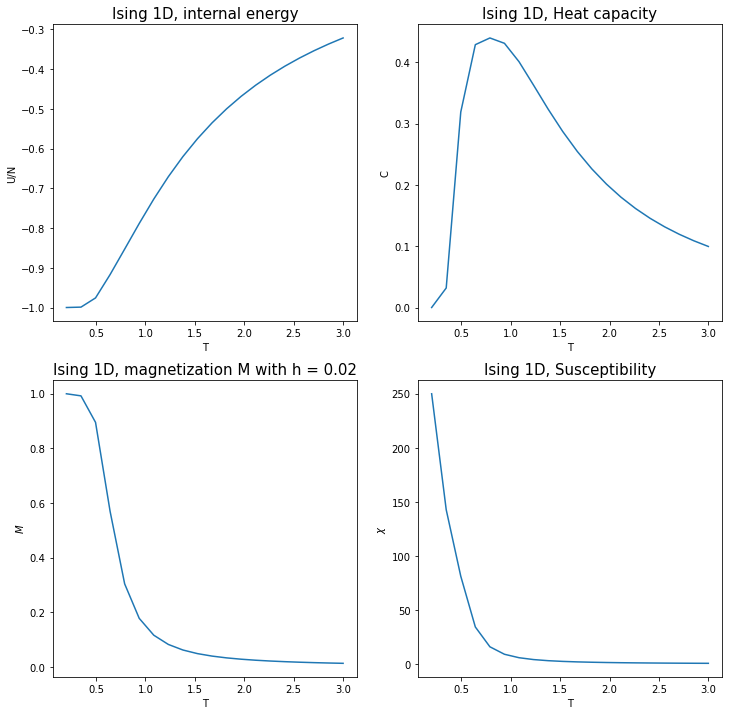

In [4]:
# (1)

points = 20
T = np.linspace(0.2, 3.0, num=points)
e = internal_energy(T)

plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.plot(T, e)
plt.title('Ising 1D, internal energy', fontsize=axesLabelSize)
plt.xlabel('T')
plt.ylabel('U/N')

# (2)

heat = heat_capacity(T)
plt.subplot(222)
plt.plot(T, heat)
plt.title('Ising 1D, Heat capacity', fontsize=axesLabelSize)
plt.xlabel('T')
plt.ylabel('C')

# (3)

H=0.02 #external field

M = magnetization(T, H)
plt.subplot(223)
plt.plot(T, M)
plt.title('Ising 1D, magnetization M with h = 0.02', fontsize=axesLabelSize)
plt.xlabel('T')
plt.ylabel('$M$')

# (4)

X = susceptibility(T)
plt.subplot(224)
plt.plot(T, X)
plt.title('Ising 1D, Susceptibility', fontsize=axesLabelSize)
plt.xlabel('T')
plt.ylabel('$\chi$')
plt.show()

Complete the C++ code to simulate 1D Ising model (It is available on the Ariel web site of this Laboratory) with 
 1. the Metropolis sampling algorithm and
 2. the Gibbs sampling algorithm

to sample the Boltzmann's weight $p(\{ s_i \}) = \exp(-\beta H)/Z$,
adding also the possibility to restart from a previous spin configuration.

The code already computes the internal energy: $U(N,T) = \langle H \rangle$. Add the calculation of $C(N,T)$, $\chi(N,T)$, $M(N,T,h)$ and compute:
1. $U(N,T) = \langle H \rangle_{h=0}$
2. $C(N,T) = k_B \beta^2 (\langle H^2 \rangle_{h=0}-\langle H \rangle_{h=0}^2)$ 
3. $\chi(N,T) = \beta \langle (\sum_{i=1,N}s_i)^2 \rangle_{h=0}$
4. $M(N,T,h=0.02)= \langle \sum_{i=1,N}s_i \rangle_{h=0.02}$

as a function of $T$ in the range $\left[0.5;2.0\right]$ for a system of $N=50$ spins with $J=1$.

As usual, use data blocking and give an estimate of the statistical uncertainties.

Show pictures of your estimations of $U(N,T)$, $C(N,T)$, $\chi(N,T)$, $M(N,T,h=0.02)$ and their uncertainties obtained with a large number of MC steps (e.g. $M\ge 10^5$) compared with the exact curves. In the same picture show your results obtained with both sampling methods, Metropolis and Gibbs.

A Monte Carlo step will consist in trying to flip one time all the spins of the system. Do not forget to equilibrate your simulations and to use blocking average with blocks large enough.

First of all, we need to equilibrate the simulation. I ran the simulation for 1000 steps at four different temperatures, starting with two different initial configurations:
 1. all spins generated randomly;
 2. all spins up.

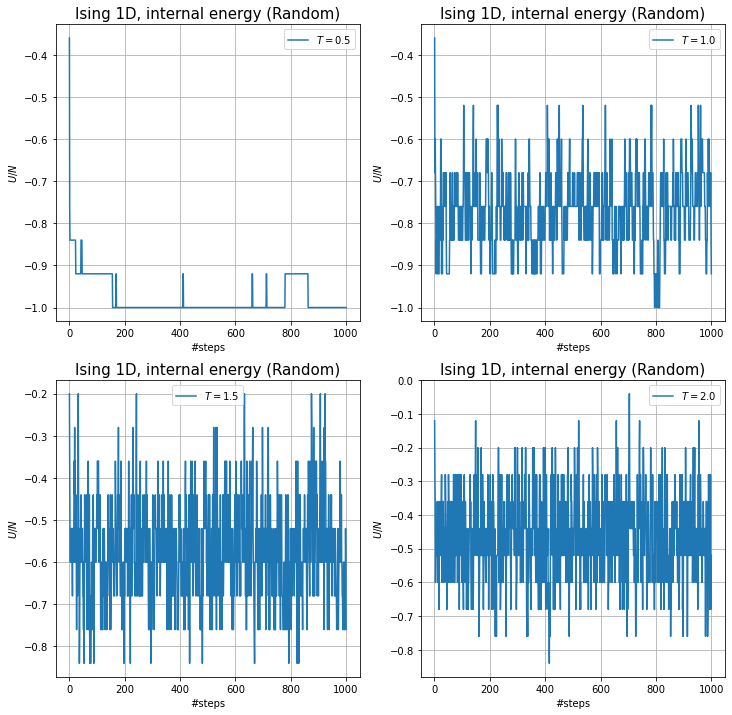

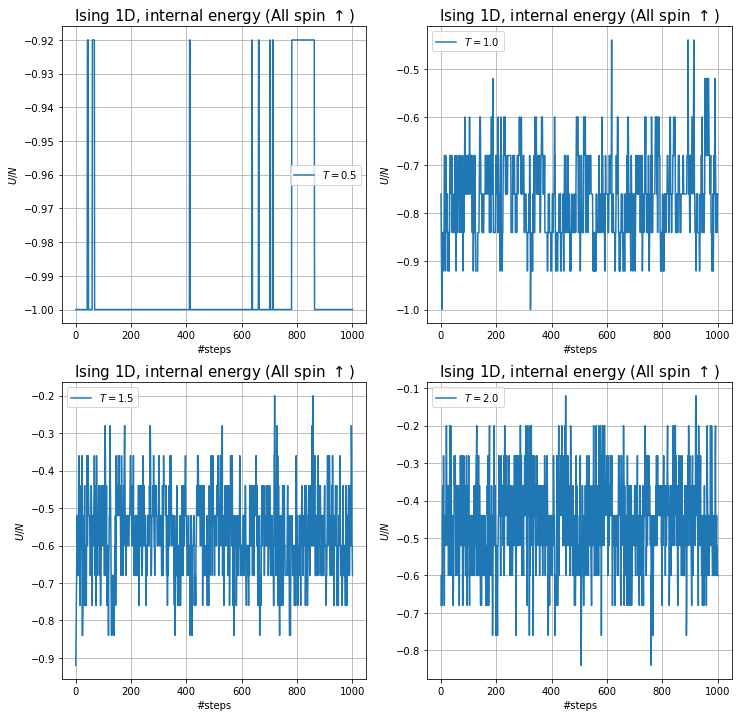

In [58]:
temperatureArray = [0.5, 1.0, 1.5, 2.0]
plt.figure(figsize=(12, 12))

# (1)

for temp in range(len(temperatureArray)):
    set_input_file(temperatureArray[temp], J, 0, nSpin, '1', 1000, 1, 'No restart', 'Not equilibrate')
    reset_simulation()
    compile_simulation()
    run_simulation()


    energyArray = []

    i = 0
    with open(sourceDirectory+'output.ene.0', 'r') as reader:
        for line in reader:
            data = line.split()
            energyArray.append(float(data[1]))
            i += 1

    step = np.arange(1, i + 1)
    plt.subplot(221 + temp)
    plt.title('Ising 1D, internal energy (Random)', fontsize=axesLabelSize)
    plt.plot(step, energyArray, label='$T = $'+str(temperatureArray[temp]))
    plt.legend()
    plt.xlabel('#steps')
    plt.ylabel('$U/N$')
    plt.grid(True)
    
plt.show()
subprocess.check_output(["/bin/sh", "-c", "cp "+sourceDirectory+"config.up "+sourceDirectory+'config.0'])
plt.figure(figsize=(12, 12))

# (2)

for temp in range(len(temperatureArray)):
    set_input_file(temperatureArray[temp], J, 0, nSpin, '1', 1000, 1, 'Restart', 'Not equilibrate')
    reset_simulation()
    compile_simulation()
    run_simulation()


    energyArray = []

    i = 0
    with open(sourceDirectory+'output.ene.0', 'r') as reader:
        for line in reader:
            data = line.split()
            energyArray.append(float(data[1]))
            i += 1

    step = np.arange(1, i + 1)
    plt.subplot(221 + temp)
    plt.title('Ising 1D, internal energy (All spin $ \\uparrow $)', fontsize=axesLabelSize)
    plt.plot(step, energyArray, label='$T = $'+str(temperatureArray[temp]))
    plt.legend()
    plt.xlabel('#steps')
    plt.ylabel('$U/N$')
    plt.grid(True)
    
subprocess.check_output(["/bin/sh", "-c", "cp "+sourceDirectory+"config.bak "+sourceDirectory+'config.0'])
plt.show()

The system seems to reach the equilibrium after 200 steps.

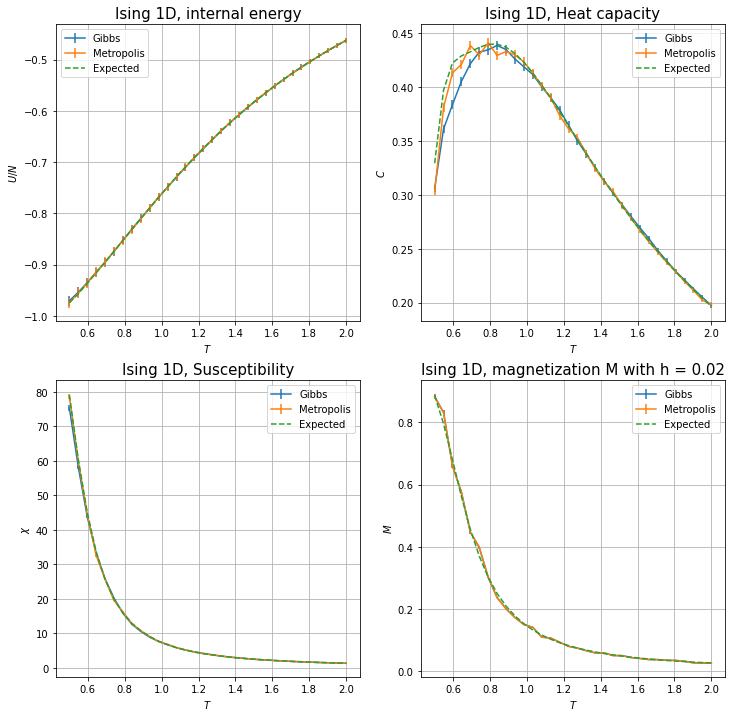

In [67]:
temperatureArray = np.linspace(0.5, 2.0, 32)

destinationDirectory = '01/'

restart = 'Restart'
h = 0.02

destinationFiles = ['output.ene.0', 'output.heat.0', 'output.chi.0', 'output.mag.0']
plotTitle = ['Ising 1D, internal energy', 'Ising 1D, Heat capacity', 'Ising 1D, Susceptibility', 'Ising 1D, magnetization M with h = '+str(0.02)]
xLabel = ['$U/N$', '$C$', '$\chi$', '$M$']
samplings = ['Gibbs', 'Metropolis']

if restart == 'Restart':
    for j in range(len(samplings)):
        for file in destinationFiles:
            with open(destinationDirectory+samplings[j]+'/'+file, 'w') as writer:
                writer.write('')
        
        for temp in temperatureArray:
            set_input_file(temp, J, 0, nSpin, str(j), blockNumber, 2000, 'Restart', 'Equilibrate')
            reset_simulation()
            compile_simulation()
            run_simulation()
    
            for i in range(len(destinationFiles) - 1):
                with open(sourceDirectory+destinationFiles[i], 'r') as reader:
                    for line in reader:
                        data = line.split()
                    average = float(data[2])
                    error = float(data[3])
        
                with open(destinationDirectory+samplings[j]+'/'+destinationFiles[i], 'a') as writer:
                    writer.write(str(temp)+' '+str(average)+' '+str(error)+'\n')
        
    
            set_input_file(temp, J, 0.02, nSpin, '1', blockNumber, 2000, 'Restart', 'Equilibrate')
            reset_simulation()
            compile_simulation()
            run_simulation()
    
            with open(sourceDirectory+destinationFiles[3], 'r') as reader:
                for line in reader:
                    data = line.split()
                average = float(data[2])
                error = float(data[3])
    
            with open(destinationDirectory+samplings[j]+'/'+destinationFiles[3], 'a') as writer:
                writer.write(str(temp)+' '+str(average)+' '+str(error)+'\n')
    
plt.figure(figsize=(12, 12))

for i in range(len(destinationFiles)):
    
    plt.subplot(221 + i)
    plt.title(plotTitle[i], fontsize=axesLabelSize)
    
    for sampling in samplings:
        average = []
        error = []
        with open(destinationDirectory+sampling+'/'+destinationFiles[i], 'r') as reader:
            for line in reader:
                data = line.split()
                average.append(float(data[1]))
                error.append(float(data[2]))
    
        plt.errorbar(temperatureArray, average, yerr=error, label=sampling)
    plt.errorbar(temperatureArray, expected_value(temperatureArray, 0.02)[i], fmt='--', label='Expected')
    plt.legend()
    plt.xlabel('$T$')
    plt.ylabel(xLabel[i])
    plt.grid(True)
    
plt.show()